# Proyek Machine Learning: Recommender System

- **Nama:** Umar Sani
- **Email:** umarsani@student.uns.ac.id
- **ID Dicoding:** umarsani16

## Import Libraries

In [2]:
import string
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval
from datetime import datetime
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import zipfile
import os, shutil

# set pandas agar tidak memotong kolom
pd.set_option("display.max_columns", 0)

## Load Data

In [3]:
# Unduh dataset dari Kaggle (jika memakai selain Kaggle Notebook)

# ! kaggle datasets download -d rounakbanik/the-movies-dataset

In [4]:
# # Ekstrak dataset
# def extract(source, destination):
#     zip = zipfile.ZipFile(source, "r")
#     zip.extractall(destination)
#     zip.close()
#     print("[SUCCESS] {} berhasil diekstrak ke '{}'".format(os.path.basename(source), destination))

# source = "/content/the-movies-dataset.zip"
# destination = "/content/the-movies-dataset"

# extract(source, destination)

In [5]:
movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv')
keywords = pd.read_csv('../input/the-movies-dataset/keywords.csv')
credits = pd.read_csv('../input/the-movies-dataset/credits.csv')

/tmp/ipykernel_183/2252133939.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv('../input/the-movies-dataset/movies_metadata.csv')


## Data Cleaning and Preprocessing

Pertama, mari kita pahami dataset dengan melihat struktur masing-masing file yang telah di-import. File-file ini nanti akan digabungkan menjadi satu dataframe

### Dataframe Movies

Mari kita lihat 5 baris data teratas, serta informasi jumlah dan tipe dataset.

In [6]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

Dari informasi diatas, dapat dilihat ada beberapa kolom yang tipe datanya object. Kolom-kolom tersebut akan kita ubah tipe datanya agar mudah untuk diolah.

In [8]:
movies['belongs_to_collection'][0]

"{'id': 10194, 'name': 'Toy Story Collection', 'poster_path': '/7G9915LfUQ2lVfwMEEhDsn3kT4B.jpg', 'backdrop_path': '/9FBwqcd9IRruEDUrTdcaafOMKUq.jpg'}"

In [9]:
movies['genres'][0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [10]:
movies['production_companies'][0]

"[{'name': 'Pixar Animation Studios', 'id': 3}]"

In [11]:
movies['production_countries'][0]

"[{'iso_3166_1': 'US', 'name': 'United States of America'}]"

In [12]:
movies['spoken_languages'][0]

"[{'iso_639_1': 'en', 'name': 'English'}]"

Drop kolom-kolom metadata yang kurang berhubungan dengan informasi movie itu sendiri. Selain itu, terdapat beberapa baris yang bertipe data salah, karena akan membuat error pada saat pengolahan data.

In [13]:
movies = movies.drop(['belongs_to_collection', 'homepage', 'imdb_id', 'poster_path', 'status', 'title', 'video'], axis=1).drop([19730, 29503, 35587])
movies.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,7.7,5415.0
1,False,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,6.1,34.0
4,False,0,"[{'id': 35, 'name': 'Comedy'}]",11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,5.7,173.0


Sekarang, kita ubah kolom-kolom yang bertipe data object menjadi list.

In [14]:
def object_to_list(x):
    if isinstance(x, str):
        names = [i['name'] for i in literal_eval(x)]
        # Jika terdapat lebih dari tiga elemen, ambil tiga pertama saja.
        if len(names) > 3:
            names = names[:3]
        return names
    else:
        return []

In [15]:
for column_name in ['production_companies', 'production_countries', 'spoken_languages', 'genres']:
    movies[column_name] = movies[column_name].apply(object_to_list)

movies.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count
0,False,30000000,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],NaN,7.7,5415.0
1,False,65000000,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Roll the dice and unleash the excitement!,6.9,2413.0
2,False,0,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Still Yelling. Still Fighting. Still Ready for...,6.5,92.0
3,False,16000000,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[English],Friends are the people who let you be yourself...,6.1,34.0
4,False,0,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,[English],Just When His World Is Back To Normal... He's ...,5.7,173.0


Sekarang, dataframe movie kita telah lebih rapi.

### Dataframe Keywords

Berikutnya, kita lihat 5 baris data teratas dari dataframe Keywords, serta informasi jumlah dan tipe dataset.

In [16]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [17]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [18]:
keywords['keywords'][0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

Sama seperti dataframe Movies, lakukan konversi tipe data object menjadi list pada kolom yang belum sesuai.

In [19]:
# data prep
keywords['keywords'] = keywords['keywords'].apply(object_to_list)
keywords.head()

,id,keywords
0,862,"[jealousy, toy, boy]"
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger]"
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence]"


### Dataframe Credits

Berikutnya, kita lihat 5 baris data teratas dari dataframe Credits, serta informasi jumlah dan tipe dataset.

In [20]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [21]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [22]:
credits['cast'][0]

"[{'cast_id': 14, 'character': 'Woody (voice)', 'credit_id': '52fe4284c3a36847f8024f95', 'gender': 2, 'id': 31, 'name': 'Tom Hanks', 'order': 0, 'profile_path': '/pQFoyx7rp09CJTAb932F2g8Nlho.jpg'}, {'cast_id': 15, 'character': 'Buzz Lightyear (voice)', 'credit_id': '52fe4284c3a36847f8024f99', 'gender': 2, 'id': 12898, 'name': 'Tim Allen', 'order': 1, 'profile_path': '/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg'}, {'cast_id': 16, 'character': 'Mr. Potato Head (voice)', 'credit_id': '52fe4284c3a36847f8024f9d', 'gender': 2, 'id': 7167, 'name': 'Don Rickles', 'order': 2, 'profile_path': '/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg'}, {'cast_id': 17, 'character': 'Slinky Dog (voice)', 'credit_id': '52fe4284c3a36847f8024fa1', 'gender': 2, 'id': 12899, 'name': 'Jim Varney', 'order': 3, 'profile_path': '/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg'}, {'cast_id': 18, 'character': 'Rex (voice)', 'credit_id': '52fe4284c3a36847f8024fa5', 'gender': 2, 'id': 12900, 'name': 'Wallace Shawn', 'order': 4, 'profile_path': '/oGE6JqPP2xH4t

In [23]:
credits['crew'][0]

'[{\'credit_id\': \'52fe4284c3a36847f8024f49\', \'department\': \'Directing\', \'gender\': 2, \'id\': 7879, \'job\': \'Director\', \'name\': \'John Lasseter\', \'profile_path\': \'/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f4f\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12891, \'job\': \'Screenplay\', \'name\': \'Joss Whedon\', \'profile_path\': \'/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f55\', \'department\': \'Writing\', \'gender\': 2, \'id\': 7, \'job\': \'Screenplay\', \'name\': \'Andrew Stanton\', \'profile_path\': \'/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f5b\', \'department\': \'Writing\', \'gender\': 2, \'id\': 12892, \'job\': \'Screenplay\', \'name\': \'Joel Cohen\', \'profile_path\': \'/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg\'}, {\'credit_id\': \'52fe4284c3a36847f8024f61\', \'department\': \'Writing\', \'gender\': 0, \'id\': 12893, \'job\': \'Screenplay\', \'name\': \'A

Sama seperti dataframe sebelumya, lakukan konversi tipe data object menjadi list pada kolom yang belum sesuai.

Selain itu, untuk kolom crew, kita hanya akan mengambil nama director-nya saja dan men-drop kolom crew itu sendiri.

In [24]:
def get_director(x):
  try:
    crew_list = literal_eval(x)
    director = [member['name'] for member in crew_list if member['job'] == 'Director']
    return director[0]
  except:
    return ''

credits['cast'] = credits['cast'].apply(object_to_list)
credits['director'] = credits['crew'].apply(get_director)

credits = credits.drop(['crew'], axis=1)

credits.head()

,cast,id,director
0,"[Tom Hanks, Tim Allen, Don Rickles]",862,John Lasseter
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]",8844,Joe Johnston
2,"[Walter Matthau, Jack Lemmon, Ann-Margret]",15602,Howard Deutch
3,"[Whitney Houston, Angela Bassett, Loretta Devine]",31357,Forest Whitaker
4,"[Steve Martin, Diane Keaton, Martin Short]",11862,Charles Shyer


In [25]:
credits['cast'][0]

['Tom Hanks', 'Tim Allen', 'Don Rickles']

### Dataset Gabungkan

Setelah setiap dataframe telah rapi, mari kita gabungkan menjadi satu dataframe.

In [26]:
movies['id'] = movies['id'].astype('int64')

df = movies.merge(keywords, on='id')
df = df.merge(credits, on='id')

df.head()

,adult,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,vote_average,vote_count,keywords,cast,director
0,False,30000000,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],NaN,7.7,5415.0,"[jealousy, toy, boy]","[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter
1,False,65000000,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Roll the dice and unleash the excitement!,6.9,2413.0,"[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston
2,False,0,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Still Yelling. Still Fighting. Still Ready for...,6.5,92.0,"[fishing, best friend, duringcreditsstinger]","[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch
3,False,16000000,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[English],Friends are the people who let you be yourself...,6.1,34.0,"[based on novel, interracial relationship, sin...","[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker
4,False,0,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,[English],Just When His World Is Back To Normal... He's ...,5.7,173.0,"[baby, midlife crisis, confidence]","[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer


Mari kita cek informasi setiap kolom dataset dan apakah ada nilai null.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46628 entries, 0 to 46627
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 46628 non-null  object 
 1   budget                46628 non-null  object 
 2   genres                46628 non-null  object 
 3   id                    46628 non-null  int64  
 4   original_language     46617 non-null  object 
 5   original_title        46628 non-null  object 
 6   overview              45633 non-null  object 
 7   popularity            46624 non-null  object 
 8   production_companies  46628 non-null  object 
 9   production_countries  46628 non-null  object 
 10  release_date          46540 non-null  object 
 11  revenue               46624 non-null  float64
 12  runtime               46360 non-null  float64
 13  spoken_languages      46628 non-null  object 
 14  tagline               20783 non-null  object 
 15  vote_average       

In [28]:
df.isnull().sum()

adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  995
popularity                  4
production_companies        0
production_countries        0
release_date               88
revenue                     4
runtime                   268
spoken_languages            0
tagline                 25845
vote_average                4
vote_count                  4
keywords                    0
cast                        0
director                    0
dtype: int64

Terdapat cukup banyak kolom yang memiliki nilai null.

Untuk kolom dengan tipe string akan kita isi dengan string kosong. Sedangkan kolom dengan tipe numerik akan kita isi dengan nilai mean.

In [29]:
fill_string = ['original_language', 'overview', 'tagline', 'release_date']

for column in fill_string:
  df[column] = df[column].fillna('')

In [30]:
df['popularity'] = df['popularity'].astype('float64')

fill_mean = ['popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']

for column in fill_mean:
  df[column] = df[column].fillna(df[column].mean())

In [31]:
df.isnull().sum()

adult                   0
budget                  0
genres                  0
id                      0
original_language       0
original_title          0
overview                0
popularity              0
production_companies    0
production_countries    0
release_date            0
revenue                 0
runtime                 0
spoken_languages        0
tagline                 0
vote_average            0
vote_count              0
keywords                0
cast                    0
director                0
dtype: int64

Sekarang, dataset kita telah bersih dari nilai null.

## Data Visualization

### Genre Movie Terbanyak

Dari visualisasi dibawah, kita dapat melihat bahwa genre film dengan jumlah terbanyak adalah drama, diikuti oleh komedi dan aksi.

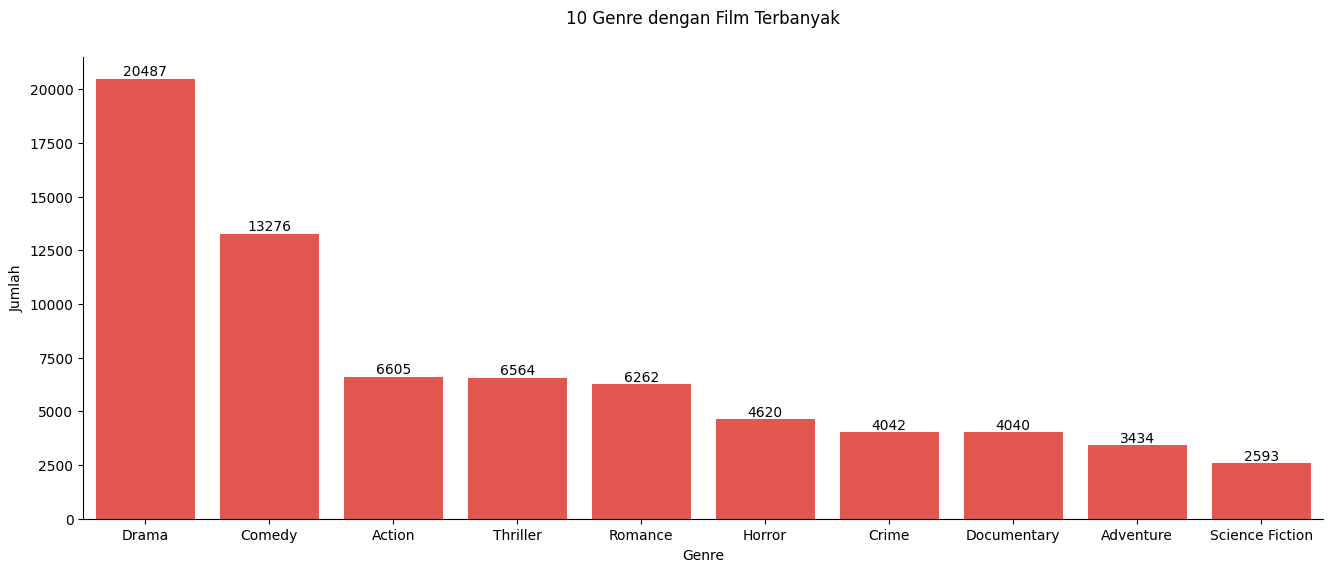

In [32]:
genres_list = []
for i in df['genres']:
    genres_list.extend(i)

fig = plt.figure(figsize=(16, 6))

df_top_10 = pd.DataFrame(Counter(genres_list).most_common(10), columns=['genre', 'total'])

ax = sns.barplot(data=df_top_10, x='genre', y='total', color='#fb4137')

ax.set_title('10 Genre dengan Film Terbanyak', pad=24)
ax.set_xlabel('Genre')
ax.set_ylabel('Jumlah')

sns.despine()

for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{}'.format(int(y)), (x.mean(), y), ha='center', va='bottom')

### Distribusi Film Berdasarkan Tanggal Rilis

Berdasarkan visualisasi di bawah, dapat dilihat bahwa produksi film meningkat pada dekade 2000 hingga sekarang.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribusi Film Berdasarkan Tanggal Rilis')

<Figure size 1600x600 with 0 Axes>

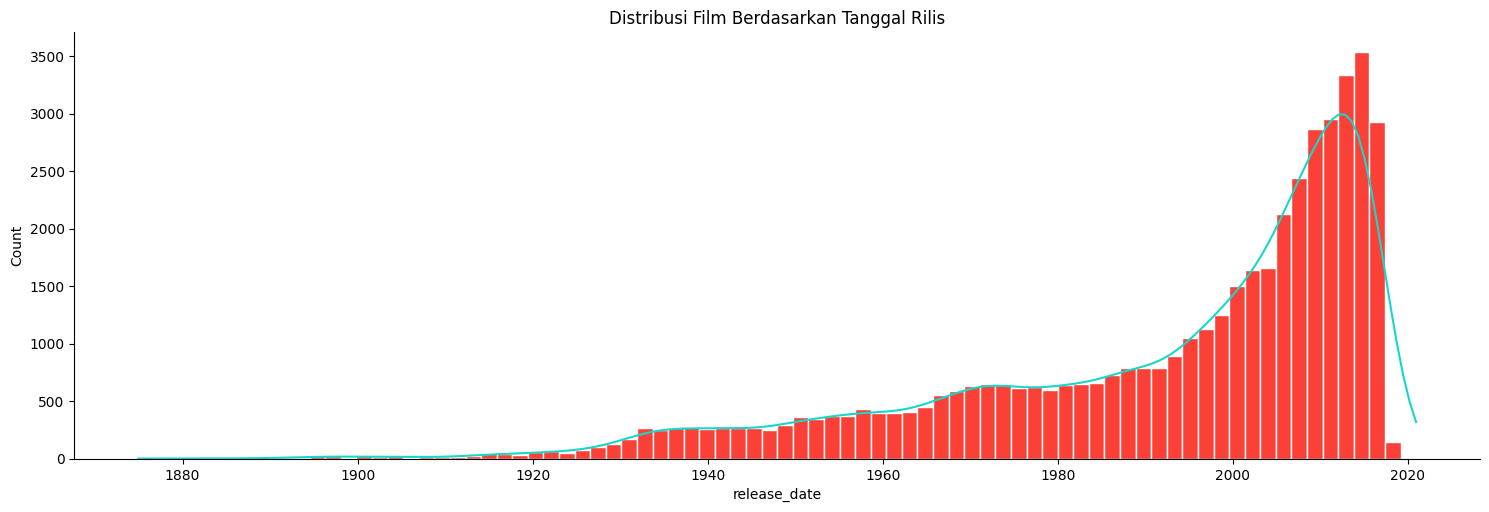

In [33]:
df['release_date'] = pd.to_datetime(df['release_date'])

fig = plt.figure(figsize=(16, 6))

sns.displot(data=df, x='release_date', kind='hist', kde=True, color='#18d7ca', facecolor='#fb4137', edgecolor='#fff', aspect=3)

plt.title('Distribusi Film Berdasarkan Tanggal Rilis')

### Word Cloud

Berdasarkan word cloud dari plot film, dapat dilihat bahwa kata yang sering muncul adalah "one", "life", "love", "find", "family", dan "live".

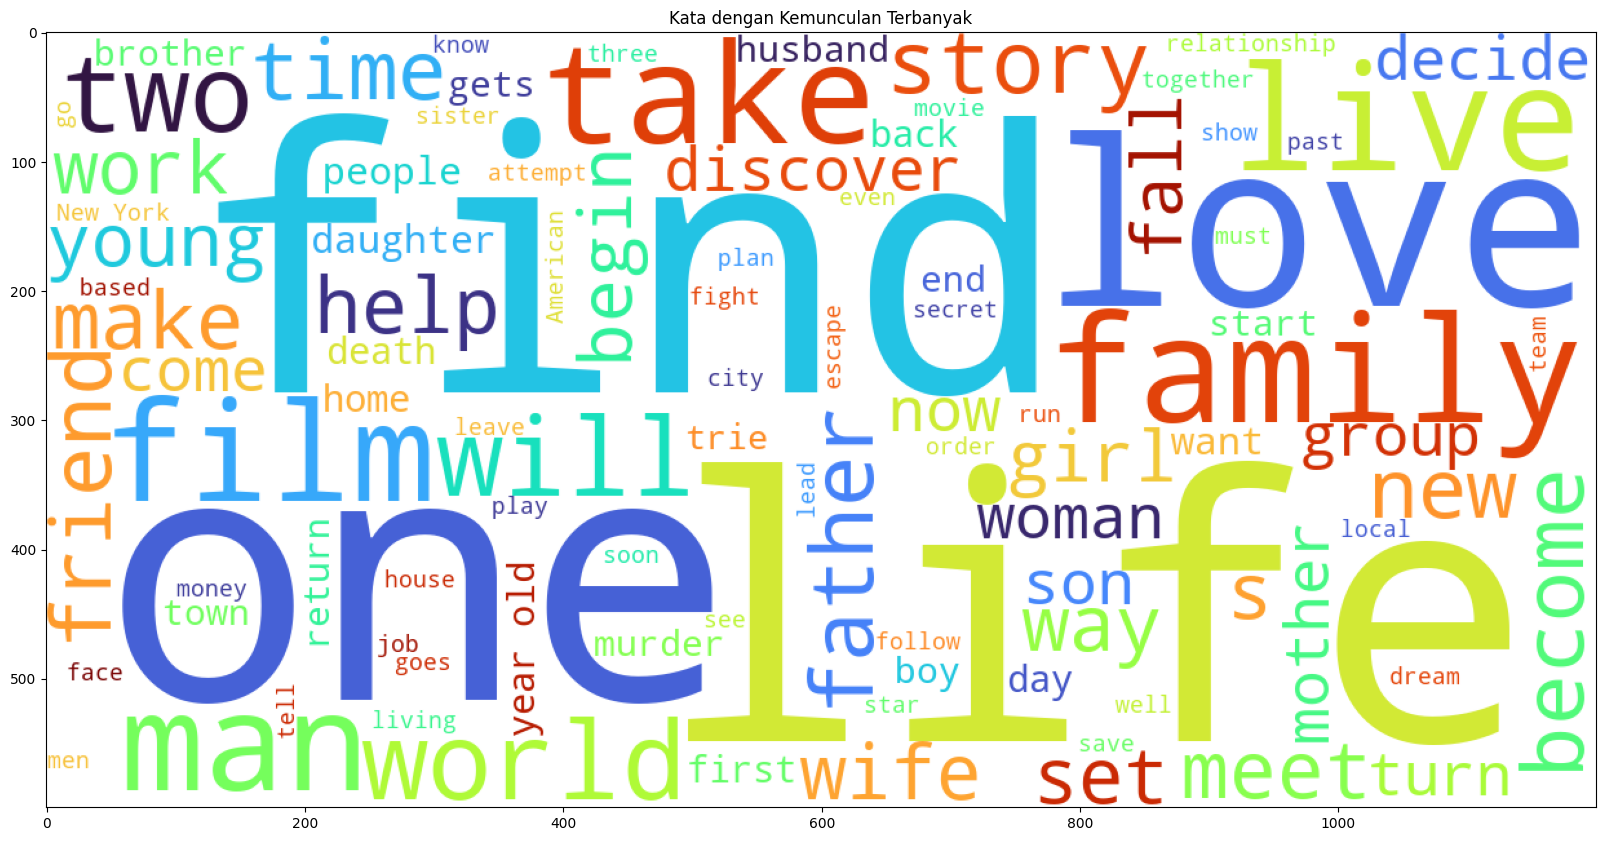

In [34]:
plt.figure(figsize=(20,20))

plt.title('Kata dengan Kemunculan Terbanyak')

wc = WordCloud(max_words=100, min_font_size=10, height=600, width=1200, background_color="white", colormap='turbo').generate(' '.join(df['overview']))

plt.imshow(wc)

## Content-based filtering

Sekarang, saatnya kita membuat sistem rekomendasi dengan pendekatan Content-based Filtering. Kita akan menggunakan metadata items, seperti genres, keywords, cast, dan director yang terkait dengan masing-masing film.

In [35]:
df[['original_title', 'genres', 'keywords', 'cast', 'director']].head()

,original_title,genres,keywords,cast,director
0,Toy Story,"[Animation, Comedy, Family]","[jealousy, toy, boy]","[Tom Hanks, Tim Allen, Don Rickles]",John Lasseter
1,Jumanji,"[Adventure, Fantasy, Family]","[board game, disappearance, based on children'...","[Robin Williams, Jonathan Hyde, Kirsten Dunst]",Joe Johnston
2,Grumpier Old Men,"[Romance, Comedy]","[fishing, best friend, duringcreditsstinger]","[Walter Matthau, Jack Lemmon, Ann-Margret]",Howard Deutch
3,Waiting to Exhale,"[Comedy, Drama, Romance]","[based on novel, interracial relationship, sin...","[Whitney Houston, Angela Bassett, Loretta Devine]",Forest Whitaker
4,Father of the Bride Part II,[Comedy],"[baby, midlife crisis, confidence]","[Steve Martin, Diane Keaton, Martin Short]",Charles Shyer


Pertama, kita akan membersihkan data dengan mengubah semua string menjadi lower case dan menghapus spasi di setiap frasanya.

In [36]:
def data_cleaning(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

content_features = ['genres', 'keywords', 'cast', 'director', ]

for feature in content_features:
    df[feature] = df[feature].apply(data_cleaning)

In [37]:
df[['original_title', 'genres', 'keywords', 'cast', 'director']].head()

,original_title,genres,keywords,cast,director
0,Toy Story,"[animation, comedy, family]","[jealousy, toy, boy]","[tomhanks, timallen, donrickles]",johnlasseter
1,Jumanji,"[adventure, fantasy, family]","[boardgame, disappearance, basedonchildren'sbook]","[robinwilliams, jonathanhyde, kirstendunst]",joejohnston
2,Grumpier Old Men,"[romance, comedy]","[fishing, bestfriend, duringcreditsstinger]","[waltermatthau, jacklemmon, ann-margret]",howarddeutch
3,Waiting to Exhale,"[comedy, drama, romance]","[basedonnovel, interracialrelationship, single...","[whitneyhouston, angelabassett, lorettadevine]",forestwhitaker
4,Father of the Bride Part II,[comedy],"[baby, midlifecrisis, confidence]","[stevemartin, dianekeaton, martinshort]",charlesshyer


Setelah itu, kita buat kolom baru dengan nama content_filter, yang merupakan string gabungan genres, keywords, cast, dan director.

In [38]:
def create_content_filter(x):
    return ' '.join(x['genres']) + ' ' + ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director']

df['content_filter'] = df.apply(create_content_filter, axis=1)
df['content_filter'].head()

0    animation comedy family jealousy toy boy tomha...
1    adventure fantasy family boardgame disappearan...
2    romance comedy fishing bestfriend duringcredit...
3    comedy drama romance basedonnovel interracialr...
4    comedy baby midlifecrisis confidence stevemart...
Name: content_filter, dtype: object

In [39]:
df['content_filter'][0]

'animation comedy family jealousy toy boy tomhanks timallen donrickles johnlasseter'

Berikutnya, kita akan melakukan vektorisasi content_filter tersebut dengan Count Vectorizer. Count Vectorizer akan menghitung frekuensi kemunculan kata dalam content_filter dan menghasilkan vektor yang mewakili jumlah kemunculan kata-kata tersebut.

Di bawah ini merupakan visualisasi dari Count Vectorizer (Shah *et al.*, 2020).

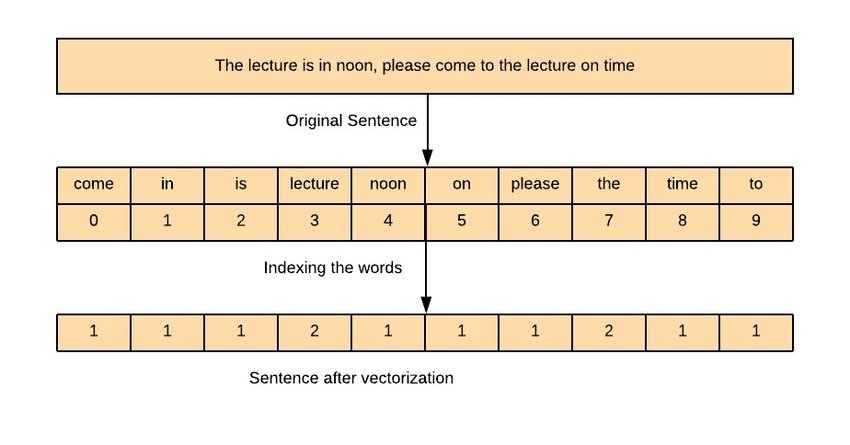

Lakukan fit_transform pada kolom content_filter yang telah dibuat.

In [40]:
cv = CountVectorizer()
vector_matrix = cv.fit_transform(df['content_filter'])

Berdasarkan matriks vektor hasil Count Vectorizer, jarak similaritas diantara setiap vektor akan dihitung dengan Cosine Similarity. 

Cosine similarity mengukur sudut kosinus antara dua vektor (Neuralis, 2023). Nilai cosine similarity berkisar antara -1 hingga 1, di mana:

- 1 menunjukkan bahwa dua vektor memiliki arah yang sama (sangat mirip).

- 0 menunjukkan bahwa dua vektor ortogonal (tidak ada kesamaan).

- -1 menunjukkan bahwa dua vektor memiliki arah yang berlawanan (sangat tidak mirip).

Di bawah ini merupakan visualisasi dari Cosine Similarity (Neuralis, 2023).

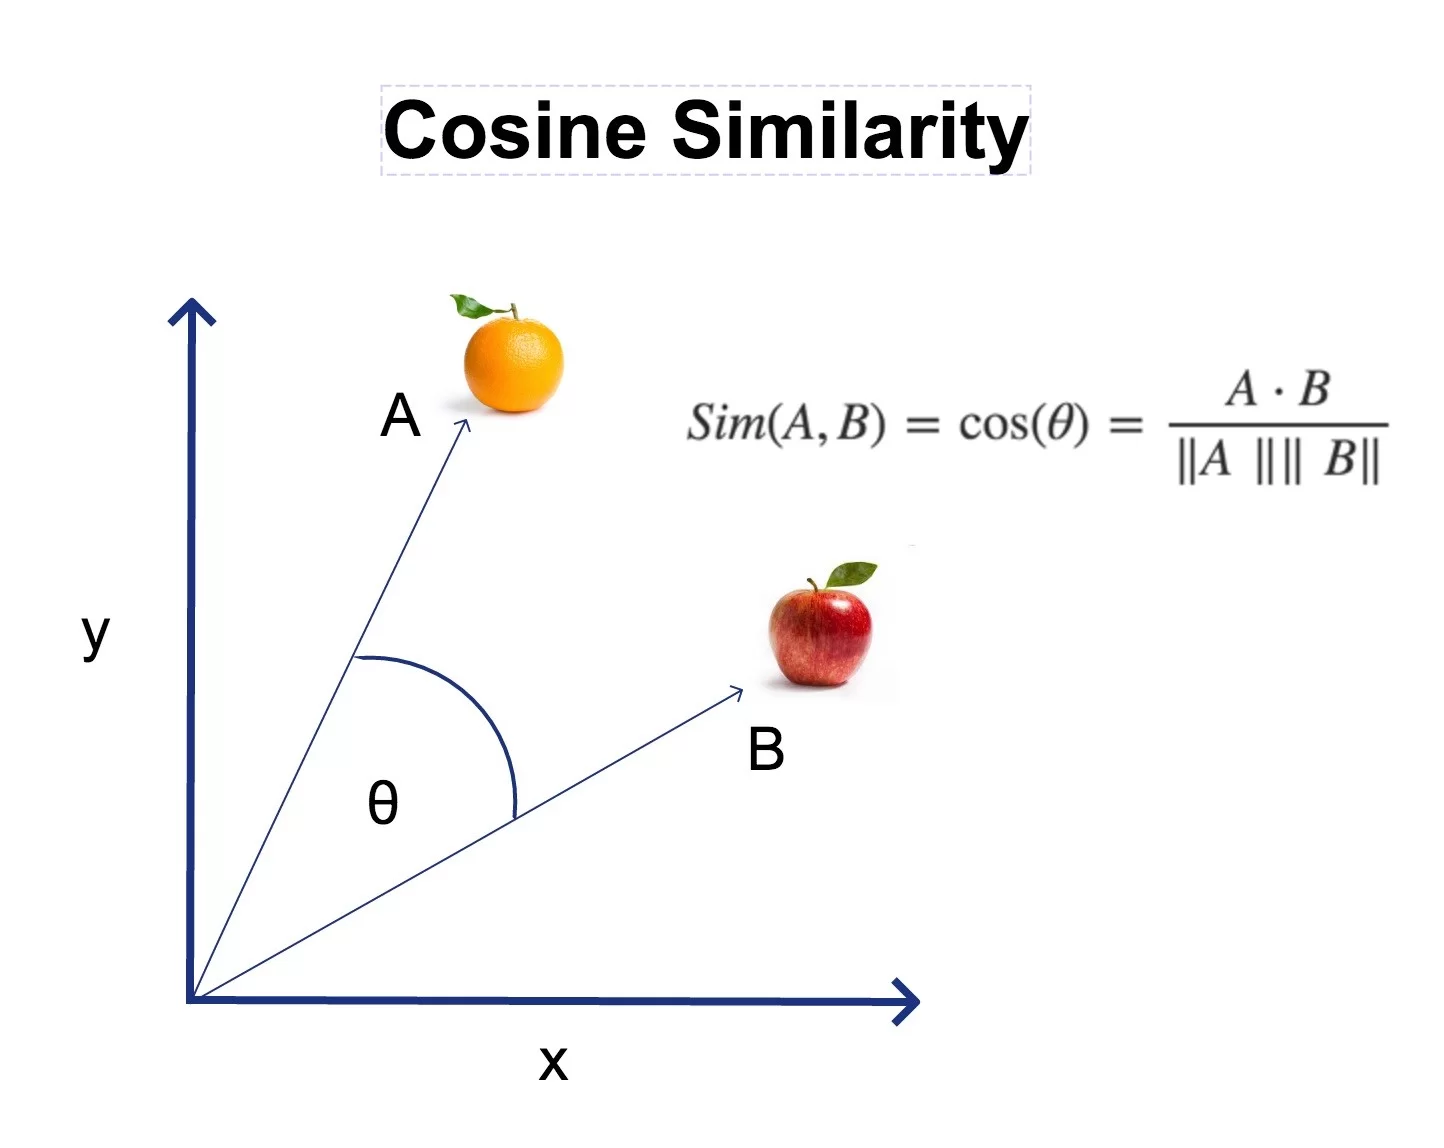

In [41]:
cos_similarity = cosine_similarity(vector_matrix, vector_matrix)

(catatan: jika menggunakan Google Colab Free, runtime akan mengalami out of memory)

Setelah kita mendapatkan matriks similaritas, buat fungsi find_recommendations untuk mendapatkan rekomendasi film. Fungsi tersebut akan menghitung jarak similaritas antara film yang diinputkan dengan film-film lainnya. Setelah itu, film-film dengan skor similaritas yang sama akan didapatkan dan diurutkan berdasarkan skor tertinggi. Kemudian, 10 besar film dengan skor similaritas tertinggi akan dikembalikan.

In [47]:
# reset index dataframe agar urut kembali
df = df.reset_index()

In [48]:
def find_recommendations(movies, cos_similarity):
    idx = movies['index'].values[0]
    sim_scores = list(enumerate(cos_similarity[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movies_idx = [i[0] for i in sim_scores]
    movies_result = df[['original_title', 'overview', 'genres', 'cast', 'vote_average']].iloc[movies_idx]
    return movies_result.reset_index()

Sebagai contoh, mari kita cari rekomendasi film yang mirip dengan film "Toy Story".

In [49]:
movie_to_find = df[df['original_title'] == 'Toy Story']

results = find_recommendations(movie_to_find, cos_similarity)

results

,index,original_title,overview,genres,cast,vote_average
0,3012,Toy Story 2,"Andy heads off to Cowboy Camp, leaving his toy...","[animation, comedy, family]","[tomhanks, timallen, joancusack]",7.3
1,15444,Toy Story 3,"Woody, Buzz, and the rest of Andy's toys haven...","[animation, family, comedy]","[tomhanks, timallen, nedbeatty]",7.6
2,29156,Superstar Goofy,,"[animation, comedy, family]",[],4.8
3,25951,Toy Story That Time Forgot,"During a post-Christmas play date, the gang fi...","[animation, family]","[tomhanks, timallen, joancusack]",6.8
4,22064,Toy Story of Terror!,What starts out as a fun road trip for the Toy...,"[animation, comedy, family]","[tomhanks, timallen, kristenschaal]",7.3
5,3324,Creature Comforts,Interviews with the public are used to put wor...,"[animation, comedy, family]",[],7.3
6,25949,Partysaurus Rex,When Rex finds himself left behind in the bath...,"[animation, comedy, family]","[tomhanks, timallen, wallaceshawn]",7.4
7,27560,Anina,Anina Yatay Salas is a ten-year-old whose name...,"[animation, comedy, family]","[federicalacaño, guillerminapardo, lucíaparrilla]",7.1
8,43059,Dexter's Laboratory: Ego Trip,After Dexter is confronted with robots who wis...,"[animation, comedy, family]",[],7.4
9,27959,Radiopiratene,Radiopiratene er høstens store familieeventyr ...,"[comedy, family]",[],0.0


Dapat kita lihat bahwa sistem rekomendasi kita berhasil membuat rekomendasi film yang mirip dengan "Toy Story".

## Evaluation

Untuk mengukur seberapa baik sistem rekomendasi kita bekerja. Kita akan menggunakan metrik precision. Metrik precision akan menghitung proporsi item yang direkomendasikan yang relevan dengan pengguna. 

Metrik precision pada sistem rekomendasi ditunjukkan oleh formula berikut.

$Precision = \frac{\text{Jumlah item relevan yang direkomendasikan}}{\text{Jumlah total item yang direkomendasikan}} $

Jumlah item relevan dalam percobaan ini kita tentukan sebagai jumlah film dengan genre yang mirip. 

Jumlah total item adalah jumlah film yang direkomendasikan oleh sistem kita.

Sebagai contoh, mari kita buat rekomendasi film berdasarkan film "Star Wars"

In [100]:
movie_to_find = df[df['original_title'] == 'Star Wars']

results = find_recommendations(movie_to_find, cos_similarity)

results

,index,original_title,overview,genres,cast,vote_average
0,1163,The Empire Strikes Back,"The epic saga continues as Luke Skywalker, in ...","[adventure, action, sciencefiction]","[markhamill, harrisonford, carriefisher]",8.2
1,1176,Return of the Jedi,As Rebel leaders map their strategy for an all...,"[adventure, action, sciencefiction]","[markhamill, harrisonford, carriefisher]",7.9
2,22831,Behind Enemy Lines,An ex-marine returns to Vietnam when he learns...,"[action, adventure]",[],6.1
3,681,Solo,An android fighting-machine (Mario Van Peebles...,"[action, adventure, sciencefiction]","[mariovanpeebles, barrycorbin, williamsadler]",3.9
4,2526,Star Wars: Episode I - The Phantom Menace,"Anakin Skywalker, a young slave strong with th...","[adventure, action, sciencefiction]","[liamneeson, ewanmcgregor, natalieportman]",6.4
5,5268,Star Wars: Episode II - Attack of the Clones,"Ten years after the invasion of Naboo, the gal...","[adventure, action, sciencefiction]","[ewanmcgregor, natalieportman, haydenchristensen]",6.4
6,7942,The Last Starfighter,A video game expert Alex Rogan finds himself t...,"[adventure, sciencefiction, action]","[lanceguest, catherinemarystewart, suzannesnyder]",6.5
7,10117,Star Wars: Episode III - Revenge of the Sith,"Years after the onset of the Clone Wars, the n...","[sciencefiction, adventure, action]","[ewanmcgregor, natalieportman, haydenchristensen]",7.1
8,22058,Ender's Game,Based on the classic novel by Orson Scott Card...,"[sciencefiction, action, adventure]","[asabutterfield, harrisonford, haileesteinfeld]",6.6
9,26720,Star Wars: The Force Awakens,Thirty years after defeating the Galactic Empi...,"[action, adventure, sciencefiction]","[daisyridley, johnboyega, adamdriver]",7.5


Kita telah mendapatkan 10 rekomendasi film yang mirip.

Untuk mendapatkan jumlah film yang relevan, kita akan menghitung similaritas genre antara movie_to_find dengan film-film hasil rekomendasi.

In [101]:
movie_to_find['genres'].tolist()[0]

['adventure', 'action', 'sciencefiction']

In [102]:
results['genres'].tolist()

[['adventure', 'action', 'sciencefiction'],
 ['adventure', 'action', 'sciencefiction'],
 ['action', 'adventure'],
 ['action', 'adventure', 'sciencefiction'],
 ['adventure', 'action', 'sciencefiction'],
 ['adventure', 'action', 'sciencefiction'],
 ['adventure', 'sciencefiction', 'action'],
 ['sciencefiction', 'adventure', 'action'],
 ['sciencefiction', 'action', 'adventure'],
 ['action', 'adventure', 'sciencefiction']]

Untuk menghitung similaritas genre antara satu film dengan film yang lain. Kita akan menggunakan jaccard similarity. Jackard similarity digunakan untuk mengukur tingkat kemiripan antara dua himpunan.

Jackard similarity ditunjukkan oleh formula berikut.

$ J(A, B) = \frac{|A \cap B|}{|A \cup B|} $

$ dengan: $

$ A = Set1 $

$ B = Set2 $

Mari kita buat fungsi untuk menghitung jaccard similarity

In [103]:
def jaccard_similarity(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    return len(intersection) / len(union)

Berikutnya, mari kita lakukan perhitungan jaccard similarity dari film yang ingin dicari dengan film-film hasil rekomendasi.

In [106]:
list_1 = movie_to_find['genres'].tolist()[0]
list_2 = results['genres'].tolist()

similarities = []

for result in list_2:
  jack_similarity = jaccard_similarity(list_1, result)
  similarities.append(jack_similarity)

jackard_result = pd.DataFrame({'Movie': range(1, len(results) + 1), 'Jaccard Similarity': similarities})

jackard_result

,Movie,Jaccard Similarity
0,1,1.000000
1,2,1.000000
2,3,0.666667
3,4,1.000000
4,5,1.000000
5,6,1.000000
6,7,1.000000
7,8,1.000000
8,9,1.000000
9,10,1.000000


Kita akan tentukan film yang relevan adalah film dengan similaritas diatas 0.8. Setelah itu, jumlah dari film yang relevan akan kita bagi dengan jumlah film rekomendasi untuk mendapatkan precision.

In [116]:
relevan_movie = jackard_result[jackard_result['Jaccard Similarity'] >= 0.8]

precision = len(relevan_movie)/len(results)

print(f"Precision: {precision*100}%")

Precision: 90.0%


Berdasarkan perhitungan diatas, kita mendapatkan precision sebesar 90%. Hasil tersebut sudah cukup bagus untuk sebuah sistem rekomendasi.

## Referensi

Neuralis. (2023, February 25). How Cosine similarity can improve your machine learning Models - AITechTrend. AITechTrend - Further into the Future. https://aitechtrend.com/how-cosine-similarity-can-improve-your-machine-learning-models/

Shah, S. R., Kaushik, A., Sharma, S., & Shah, J. (2020). Opinion-mining on marglish and devanagari comments of youtube cookery channels using parametric and non-parametric learning models. Big Data and Cognitive Computing, 4(1), 3.
